In [1]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
def ece_eval(preds, targets, n_bins=10, bg_cls = 0):
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds, 1), np.argmax(preds, 1)
    confidences, predictions = confidences[targets>bg_cls], predictions[targets>bg_cls]
    accuracies = (predictions == targets[targets>bg_cls]) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm

In [3]:
def reliability_diagram(conf_avg, acc_avg, ece_avg, legend=None, leg_idx=0, n_bins=10):
    
    plt.figure()
    #plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot([conf_avg[acc_avg>0][0], 1], [conf_avg[acc_avg>0][0], 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    #plt.xticks(np.arange(0, 1.1, 1/n_bins))
    #plt.title(title)
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.title(ece_avg)
#     plt.legend()
#     plt.savefig('ece_reliability.png',dpi=300)

# prostate dataset

In [4]:
data_root = '/home/ar88770/MarginLoss/promise/valid'
files = glob.glob('{}/*.h5'.format(data_root))

In [5]:
model_path_ce = '/home/ar88770/MarginLoss/outputs/prostate/unet-ce-adam/20220323-23:15:13-775706/best.pth'
model_path_focal = '/home/ar88770/MarginLoss/outputs/prostate/unet-focal-adam/20220323-23:56:57-787599/best.pth'
model_path_penalty = '/home/ar88770/MarginLoss/outputs/prostate/unet-penalty_ent-adam/20220324-01:10:25-247285/best.pth'
model_path_ls = '/home/ar88770/MarginLoss/outputs/prostate/unet-ls-adam/20220324-00:39:11-733687/best.pth'
model_path_margin = '/home/ar88770/MarginLoss/outputs/prostate/unet-logit_margin-adam/20220324-14:58:12-319526/best.pth'
models_path = [model_path_ce, model_path_penalty, model_path_focal, model_path_ls, model_path_margin]
method_names =['ce','penalty','focal','ls','margin']

In [6]:
model = UNet(input_channels=1, num_classes=2)

/home/ar88770/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:104: UserWarning: 
NVIDIA RTX A6000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70 sm_75.
If you want to use the NVIDIA RTX A6000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
100%|██████████| 530/530 [00:03<00:00, 168.14it/s]


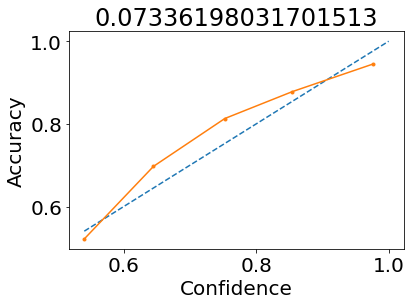

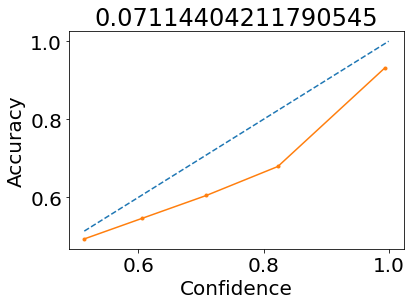

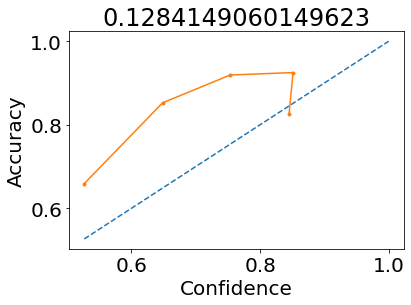

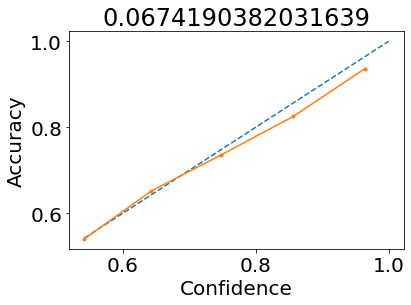

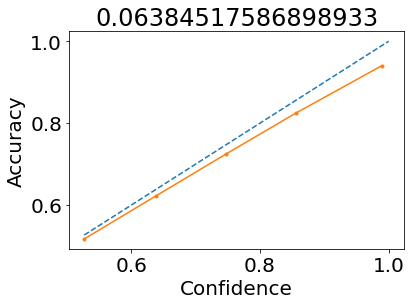

In [7]:
for key, model_path in zip(['ce', 'focal','penalty','ls','margin'],models_path):

    checkpoint = torch.load(model_path)["state_dict"]
    checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
    model.load_state_dict(checkpoint)
    model = model.to('cuda:4')
    
    ece_all, acc_all, conf_all = [], [], []

    for fpath in tqdm(files):

        with h5py.File(fpath, 'r') as hf:
            img = hf['img'][:]
            mask = hf['mask'][:]

        imgT = torch.from_numpy(img)
        imgT = imgT.unsqueeze(0).unsqueeze(0)
        imgT = imgT.cuda('cuda:4')

        target = np.expand_dims(mask,axis=0)


        predT = model(imgT.float())
        outputT = F.softmax(predT,dim=1)
        output = outputT.detach().cpu().numpy()

        ece, acc, conf, _ = ece_eval(output, target)

        ece_all.append(ece)
        acc_all.append(acc)
        conf_all.append(conf)

    ece_avg = np.stack(ece_all).mean(0)
    acc_avg = np.stack(acc_all).mean(0)
    conf_avg = np.stack(conf_all).mean(0)
    reliability_diagram(conf_avg, acc_avg, ece_avg)

# cardiac dataset

In [8]:
data_root = '/home/ar88770/MarginLoss/acdc/valid'
files = glob.glob('{}/*.h5'.format(data_root))

In [9]:
model_path_ce = '/home/ar88770/MarginLoss/outputs/cardiac/unet-ce-adam/20220323-20:17:06-951406/best.pth'
model_path_focal = '/home/ar88770/MarginLoss/outputs/cardiac/unet-focal-adam/20220323-21:00:04-839009/best.pth'
model_path_penalty = '/home/ar88770/MarginLoss/outputs/cardiac/unet-penalty_ent-adam/20220323-22:46:02-093977/best.pth'
model_path_ls = '/home/ar88770/MarginLoss/outputs/cardiac/unet-ls-adam/20220324-17:38:33-210962/best.pth'
model_path_margin = '/home/ar88770/MarginLoss/outputs/cardiac/unet-logit_margin-adam/20220324-14:58:28-642625/best.pth'
models_path = [model_path_ce, model_path_penalty, model_path_focal, model_path_ls, model_path_margin]
method_names =['ce','penalty','focal','ls','margin']

In [10]:
model = UNet(input_channels=1, num_classes=4)

In [ ]:
for key, model_path in zip(['ce', 'focal','penalty','ls','margin'],models_path):

    checkpoint = torch.load(model_path)["state_dict"]
    checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
    model.load_state_dict(checkpoint)
    model = model.to('cuda:4')
    
    ece_all, acc_all, conf_all = [], [], []

    for fpath in tqdm(files):

        with h5py.File(fpath, 'r') as hf:
            img = hf['img'][:]
            mask = hf['mask'][:]
            
        img = np.pad(img,pad_width=((5,5),(5,5)),mode='constant')
        mask = np.pad(mask,pad_width=((5,5),(5,5)),mode='constant')

        imgT = torch.from_numpy(img)
        imgT = imgT.unsqueeze(0).unsqueeze(0)
        imgT = imgT.cuda('cuda:4')

        target = np.expand_dims(mask,axis=0)


        predT = model(imgT.float())
        outputT = F.softmax(predT,dim=1)
        output = outputT.detach().cpu().numpy()

        ece, acc, conf, _ = ece_eval(output, target)

        ece_all.append(ece)
        acc_all.append(acc)
        conf_all.append(conf)

    ece_avg = np.stack(ece_all).mean(0)
    acc_avg = np.stack(acc_all).mean(0)
    conf_avg = np.stack(conf_all).mean(0)
    reliability_diagram(conf_avg, acc_avg, ece_avg)

 21%|██        | 113/532 [00:00<00:02, 157.57it/s]